<h1>DSCI-552 Homework 6</h1>
<br>
<font size="4">Morgan Gautho | GitHub: morgangauth | 3944-8632-72</font>
    

In [3]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn import tree
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import cv
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# 1. Tree-Based Methods

## (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [4]:
trainingData = pd.read_csv("../data/aps_failure_training_set.csv", skiprows= 20 )
trainingData.head()

testData = pd.read_csv("../data/aps_failure_test_set.csv", skiprows= 20 )
testData.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


## (b) Data Preparation
### This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. 
### i. Research what types of techniques are usually used for dealing with data with missing values.2 Pick at least one of them and apply it to this data in the next steps.3

Data imputation techniques include: 
1. "do-nothing", which lets the algorithm handle the missing data. This is not advised as some algorithms will panic and throw errors, or you may not be expecting how they handled it. 
2. Mean/Median values: this is done by calculating the mean or median of the existing values in a column and then replacing the missing values with this number
3. Most Frequent or constant values: This is done by replacing missing values with the mode, or most frequently seen value. This can introduce bias however
4. k-NN: this will look for nearby features and decide what the most likely value should be based on k nearest neigbors 
5. MICE, or multivariate imputation by chained equation. This replaces the values multiple times .
6. Deep learning: find the missing values by running a deep learning model which will learn the values.

I will choose to fill the missing values with the mean. 

In [5]:
shape = trainingData.shape
allData = pd.concat([trainingData, testData])


allData = allData.replace("na", np.nan)
allData = allData.apply(pd.to_numeric, errors='ignore')
allData = allData.fillna(value = allData.mean())

trainingData = allData.iloc[:shape[0],:]
testData = allData.iloc[shape[0]:,:]

allData.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.00000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,0.72556,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean

In [4]:
cvVals = pd.DataFrame({"mean": allData.mean(), "std":allData.std(), "cv": allData.std()/allData.mean() })
display(cvVals)

,mean,std,cv
aa_000,6.115976e+04,2.647366e+05,4.328608
ab_000,7.255604e-01,1.580468e+00,2.178273
ac_000,3.564398e+08,7.726379e+08,2.167653
ad_000,1.506300e+05,3.113845e+07,206.721500
ae_000,6.736959e+00,1.501915e+02,22.293670
...,...,...,...
ee_007,3.475611e+05,1.697870e+06,4.885098
ee_008,1.398968e+05,4.665609e+05,3.335037
ee_009,8.424984e+03,4.847679e+04,5.753933
ef_000,8.519734e-02,4.082618e+00,47.919544


### iii. Plot a correlation matrix for your features using pandas or any other tool.

          aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.019725 -0.011658 -0.000541  0.025795  0.035994  0.011682   
ab_000  0.019725  1.000000 -0.010898  0.000066  0.024869  0.043276  0.000590   
ac_000 -0.011658 -0.010898  1.000000 -0.002030 -0.004769 -0.010612  0.015534   
ad_000 -0.000541  0.000066 -0.002030  1.000000 -0.000195 -0.000236 -0.000038   
ae_000  0.025795  0.024869 -0.004769 -0.000195  1.000000  0.829986 -0.000441   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.356969  0.013598 -0.018631 -0.000462  0.036619  0.046482  0.007631   
ee_008  0.259668  0.002371  0.010435 -0.000794 -0.008393 -0.010843  0.000067   
ee_009  0.133764  0.000506  0.017293 -0.000500 -0.006952 -0.008539 -0.001103   
ef_000  0.006688  0.046897 -0.006191 -0.000082  0.063587  0.093474 -0.000076   
eg_000  0.010330  0.075683  0.015826 -0.000091  0.030854  0.044368  0.000156   

          ag_001    ag_002    ag_003  .

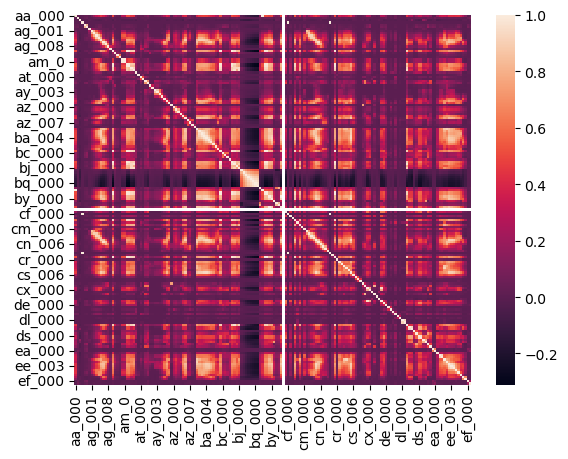

In [5]:
corr_matrix = allData.corr()
print(corr_matrix)
sns.heatmap(corr_matrix)
plt.show()

### iv. Pick √170 features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [6]:
sortedcv = cvVals.sort_values(by=['cv'], ascending=False)
sortedcv = sortedcv.iloc[:(int(math.sqrt(170))),:]
display(sortedcv.index)
topFeatures = allData.loc[:,sortedcv.index]
topFeatures = topFeatures.reset_index(drop=True)
classList = allData.iloc[:,0]
classList = classList.reset_index(drop=True)
topFeatures['class'] = classList
topFeatures.head()



Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'as_000', 'dh_000',
       'df_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009'],
      dtype='object')

,cf_000,co_000,ad_000,cs_009,dj_000,as_000,dh_000,df_000,ag_000,au_000,ak_000,az_009,ay_009,class
0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
1,150231.156793,150517.375485,150629.962105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
2,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
3,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
4,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg


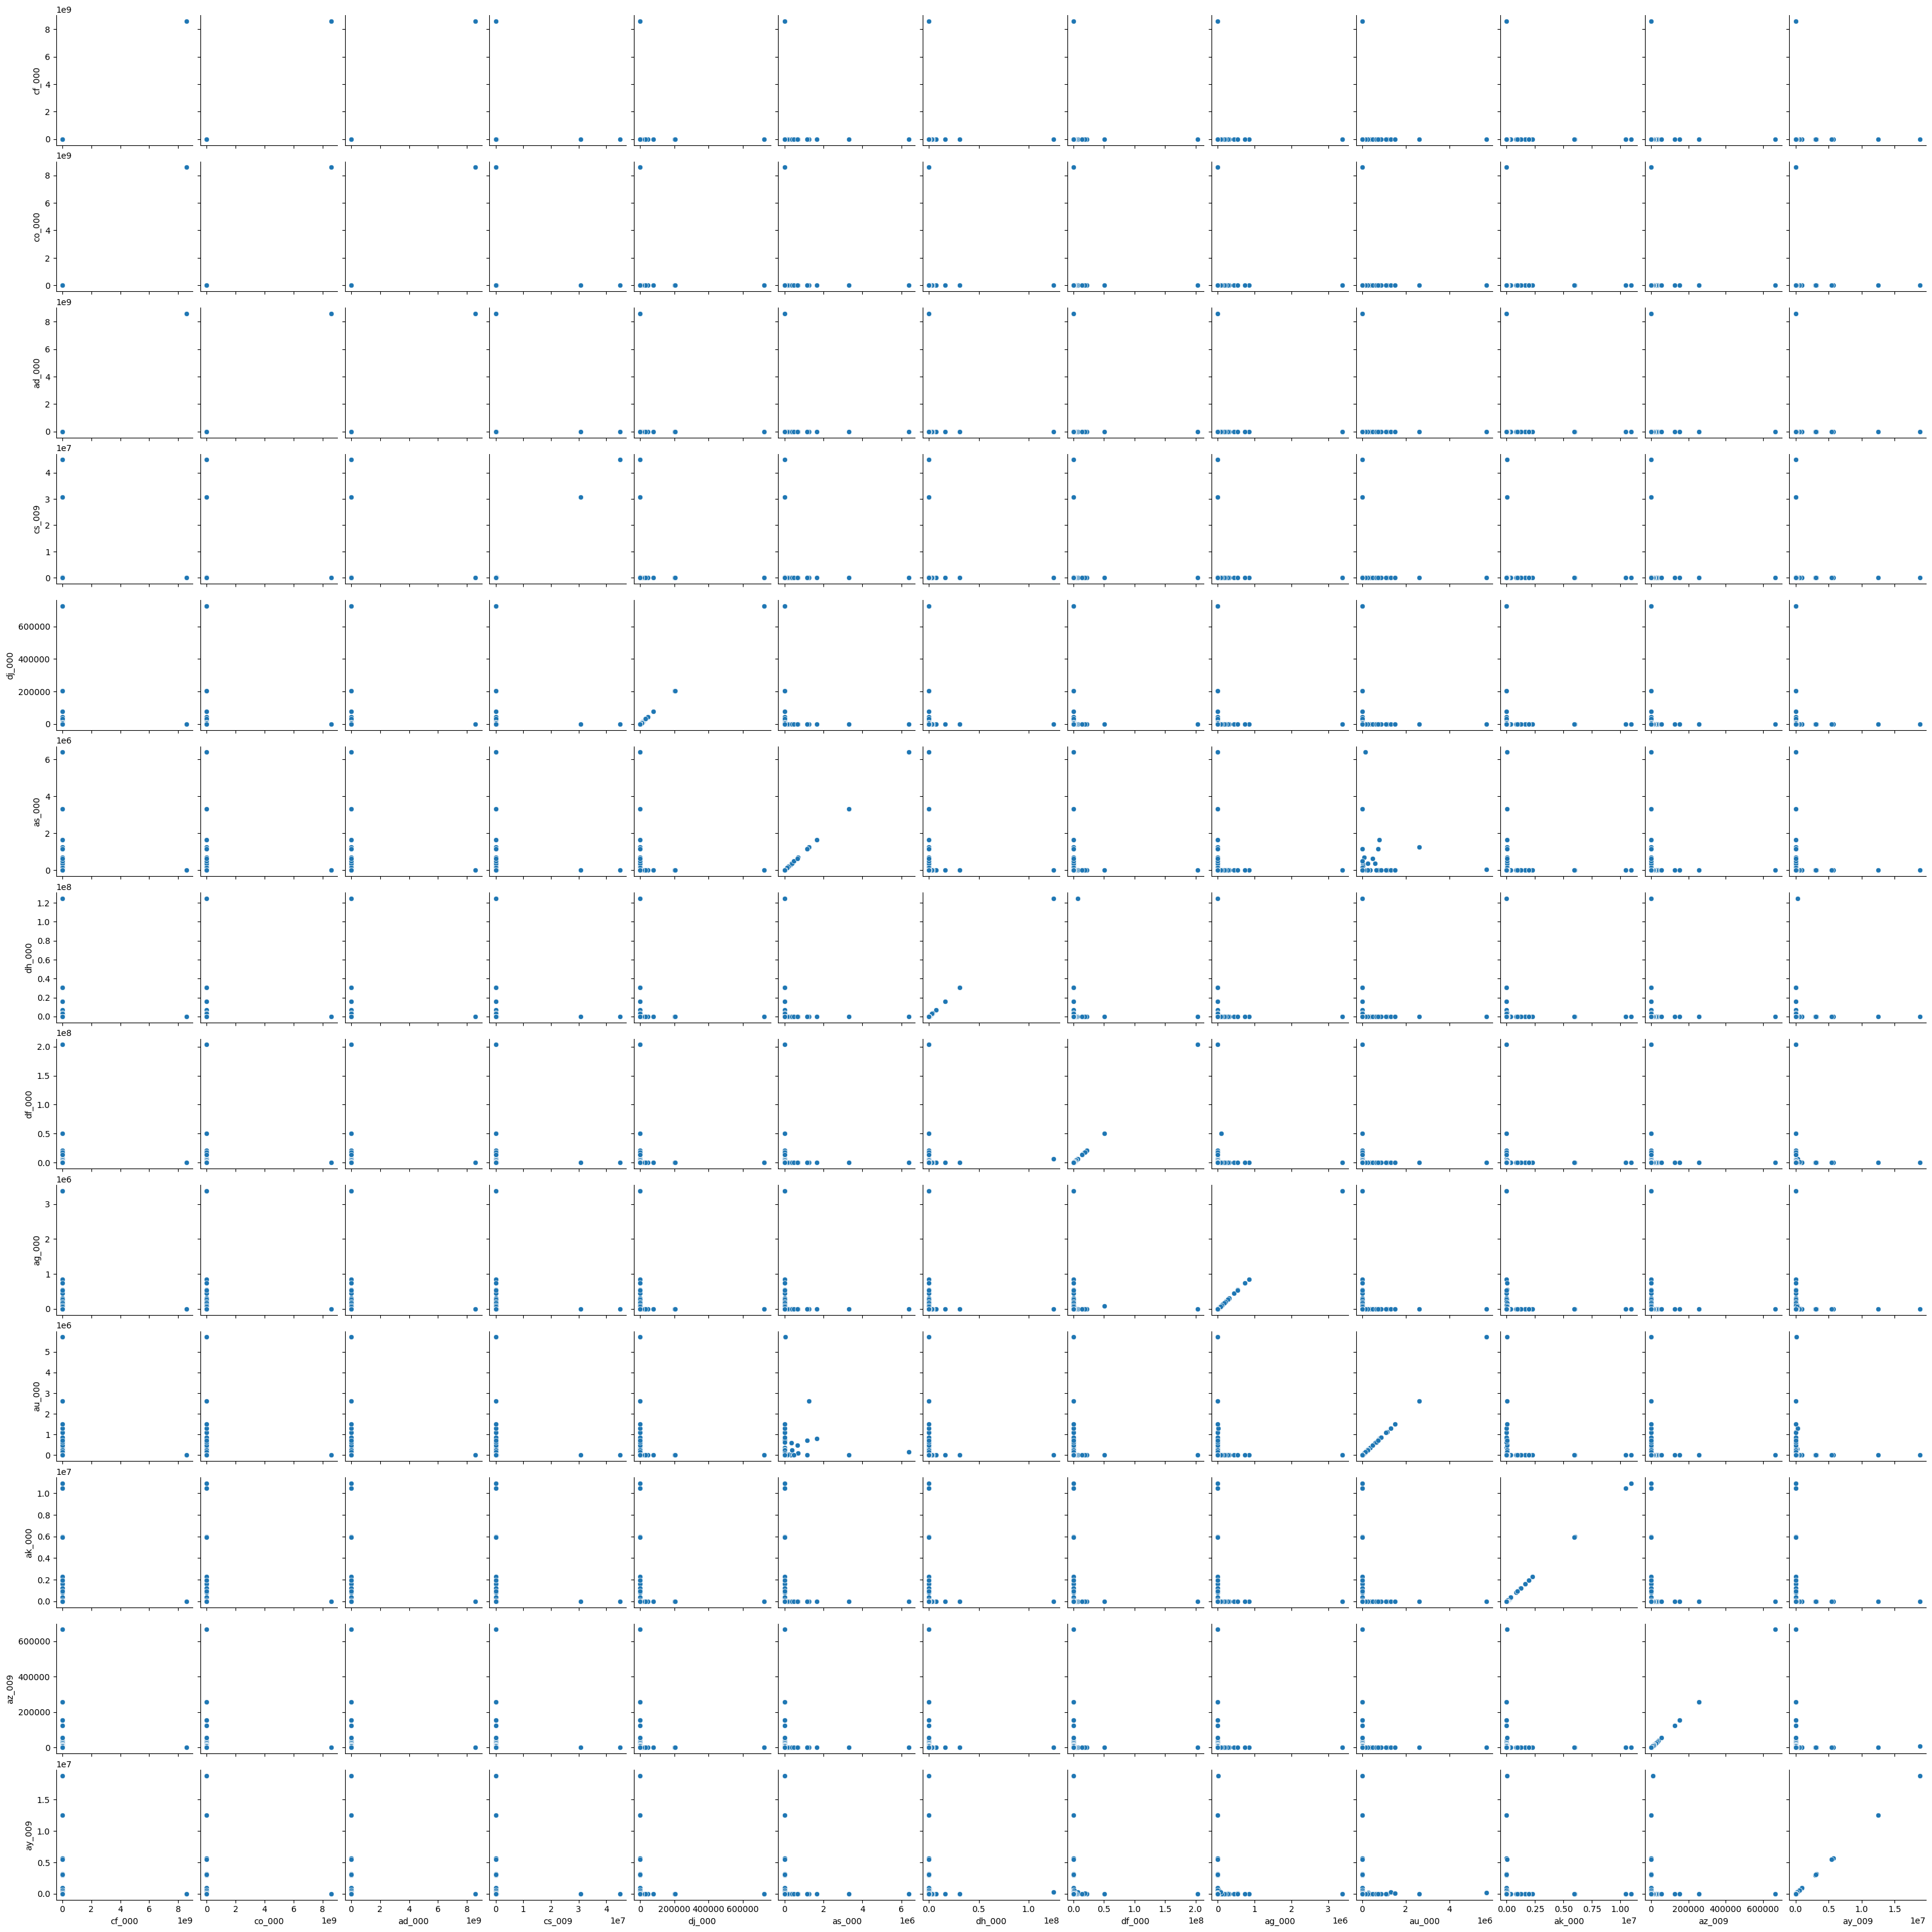

In [12]:
#scatter plots
sns.pairplot(topFeatures, diag_kind=None)
plt.show()

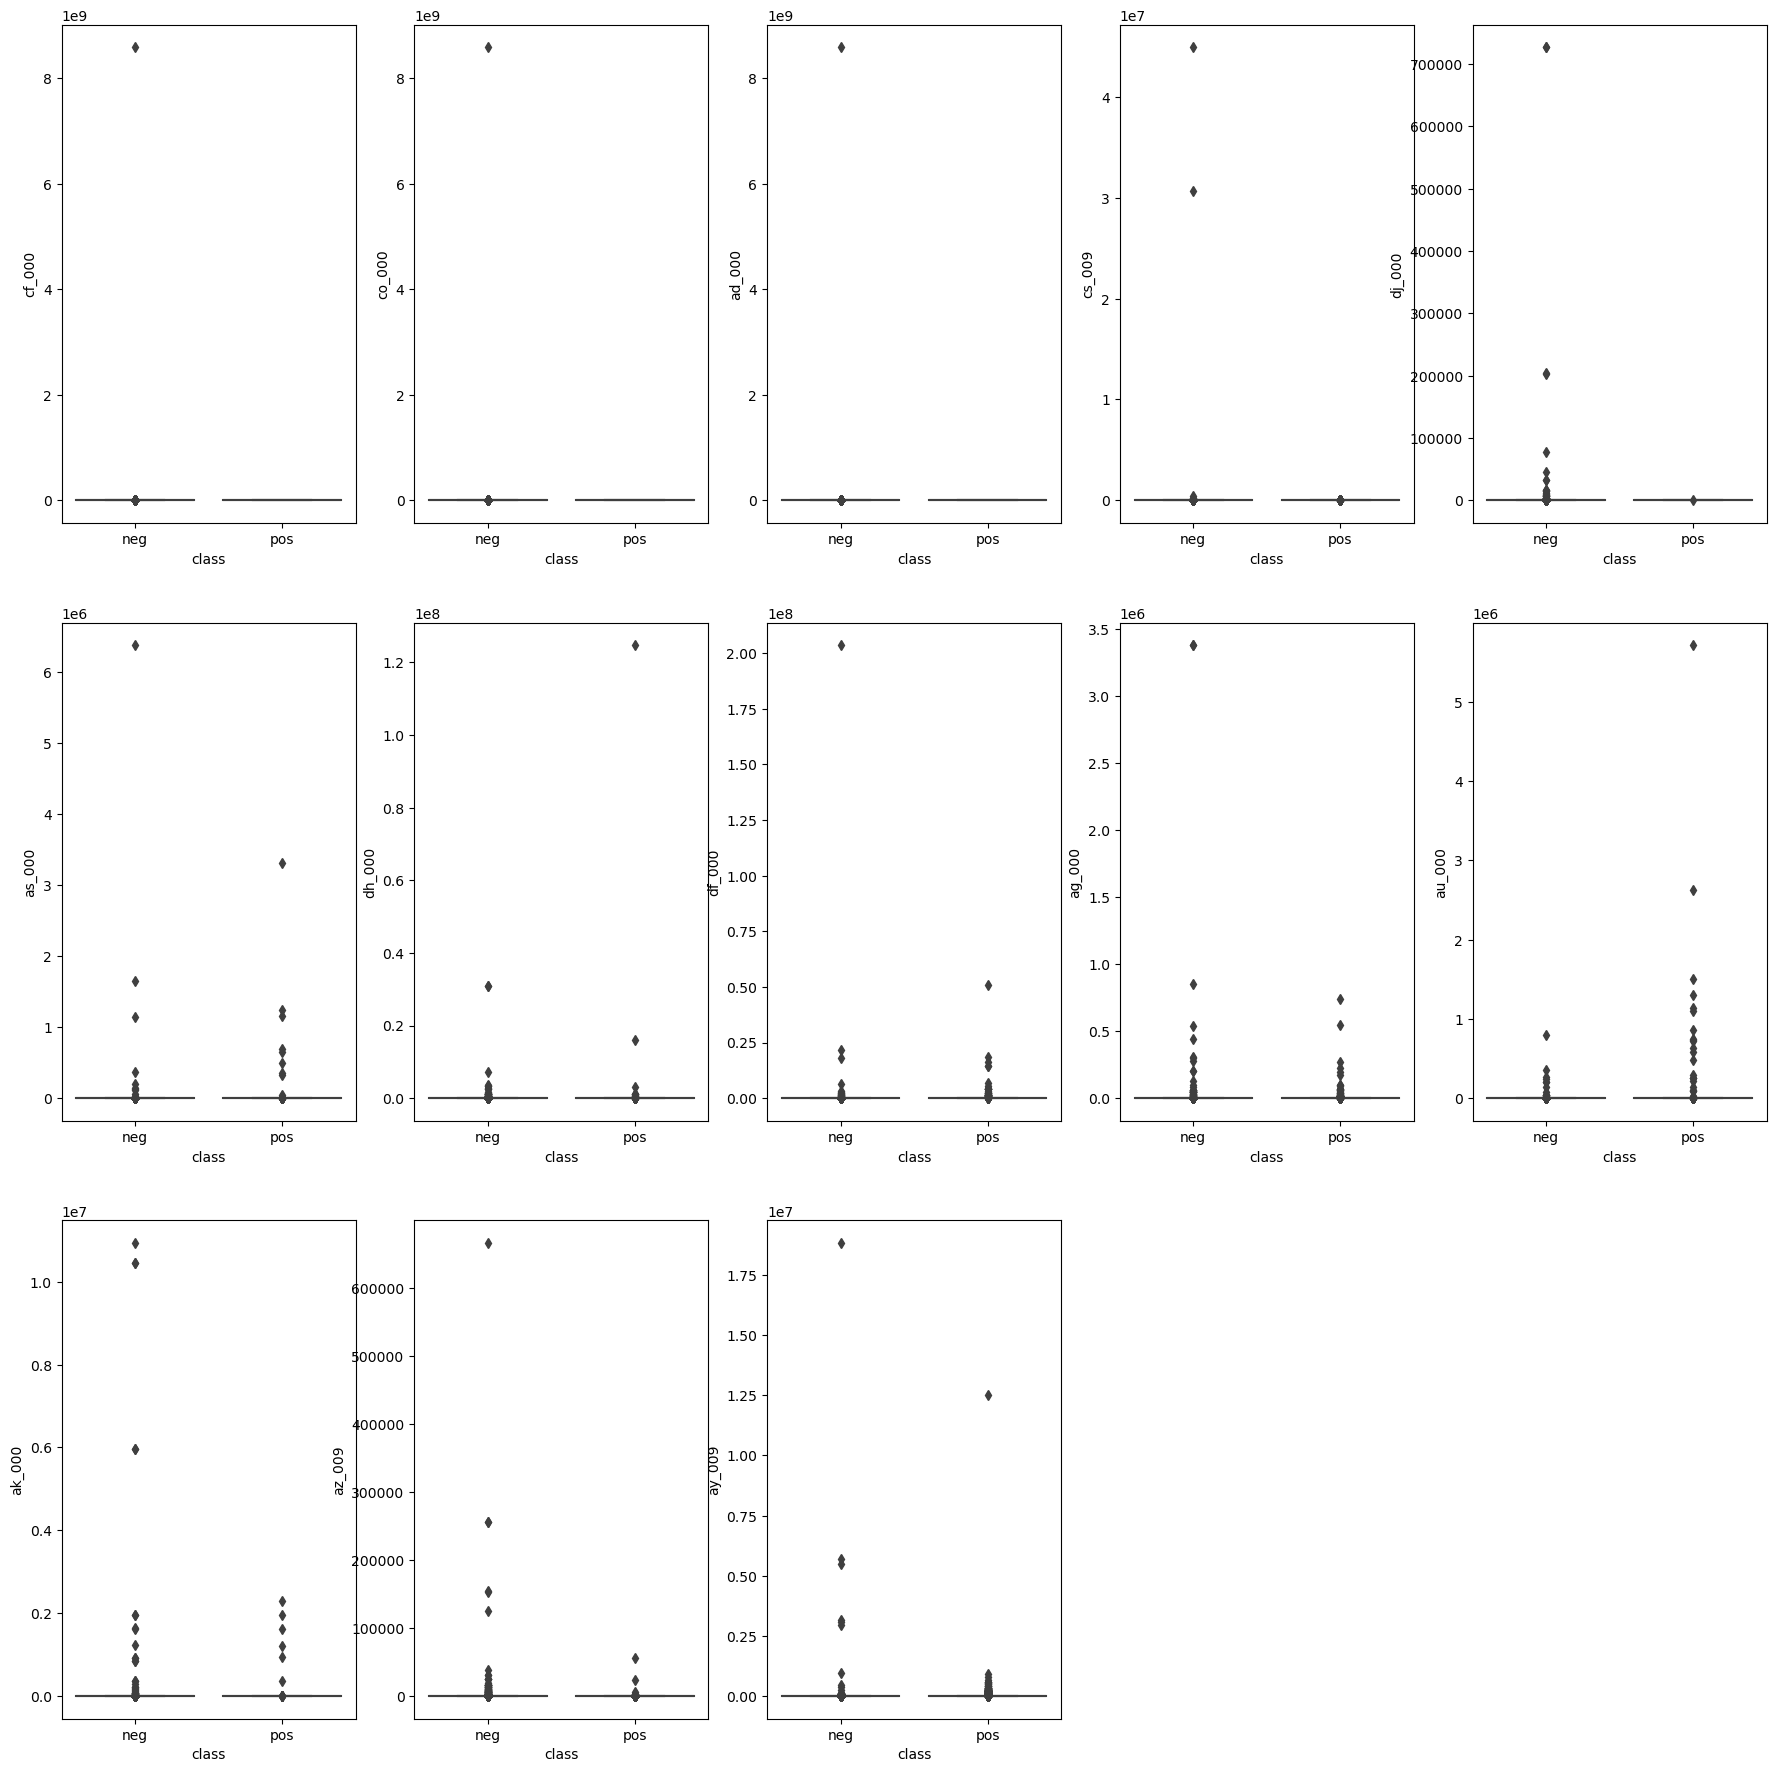

In [19]:
#boxplots
plt.figure(figsize=(22,22))
index = 1
for i in range(0, np.shape(topFeatures)[1]-1): #remove class columns
    plt.subplot(3,5,index)
    sns.boxplot(y = sortedcv.index[i], data = topFeatures, x = 'class')
    index +=1

### v. Determine the number of positive and negative data. Is this data set imbalanced?



In [6]:
posData = allData[allData['class'] == "pos"]
negData = allData[allData['class'] == "neg"]


print("The number of positive data in the set is: ", posData.shape[0], "and the number of negative data in the set is: ", negData.shape[0])
print("This means the percentage of the total data which is negative is ", 100 * posData.shape[0]/allData.shape[0], "%, which is a very small amount compared to the ",100 * negData.shape[0]/allData.shape[0], "% of negative data, so this is an imbalanced data set."  )

The number of positive data in the set is:  1375 and the number of negative data in the set is:  74625
This means the percentage of the total data which is negative is  1.8092105263157894 %, which is a very small amount compared to the  98.1907894736842 % of negative data, so this is an imbalanced data set.


## (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.


In [7]:
# ONLY run once
# Train the model using the training sets
trainingData['class'] = trainingData['class'].apply( lambda x: 1 if x == 'pos' else 0)
testData['class'] = testData['class'].apply(lambda x: 1 if x == 'pos' else 0)
X_train = trainingData.iloc[:,1:]
y_train = trainingData.iloc[:,0]
X_test = testData.iloc[:,1:]
y_test = testData.iloc[:,0]

[[59000     0]
 [    0  1000]]


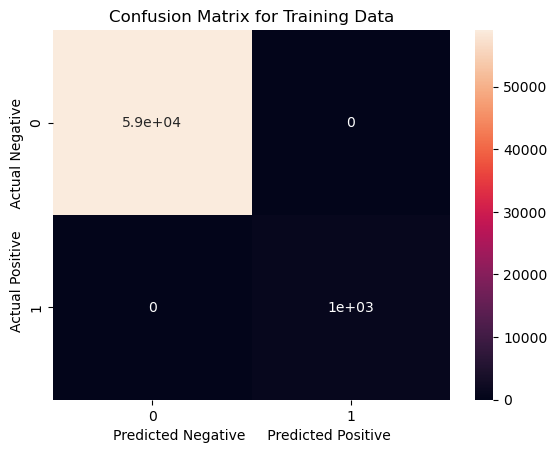

[[15608    17]
 [  111   264]]


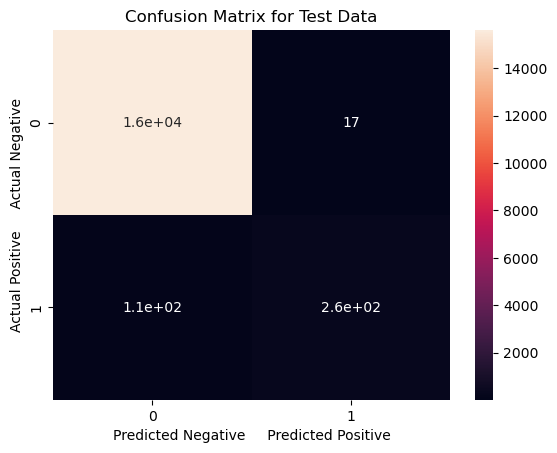

In [8]:
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_train)
y_predict_test = clf.predict(X_test)


#confusion matrix
trainMatrix = confusion_matrix(y_train,y_predict)
print(trainMatrix)
sns.heatmap(trainMatrix,annot = True)
plt.title("Confusion Matrix for Training Data")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()

testMatrix = confusion_matrix(y_test,y_predict_test)
print(testMatrix)
sns.heatmap(testMatrix,annot = True)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()

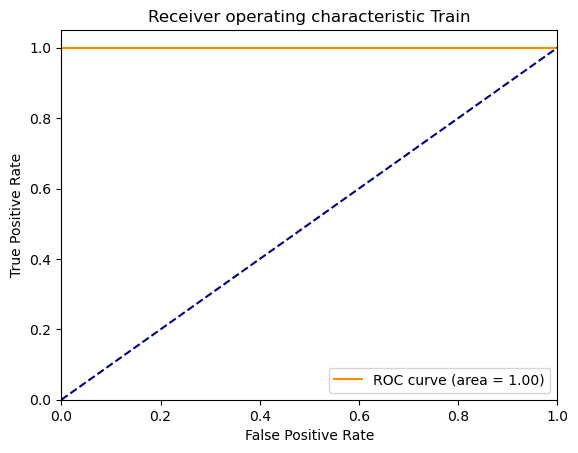

Training misclassification rate is:  0.0


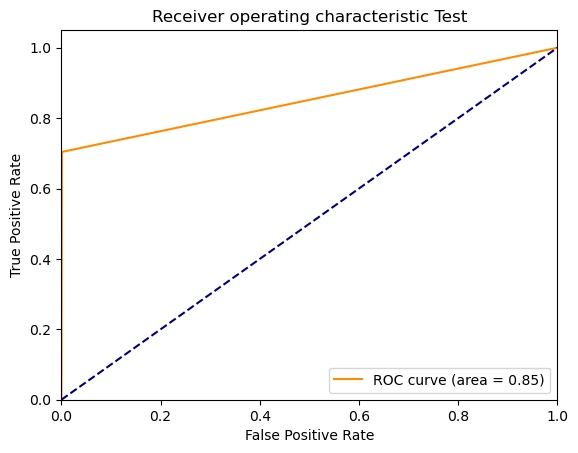

Test misclassification rate is:  0.008000000000000007
The Out of Bag error is:  0.006216666666666648  and the test error is  0.008000000000000007
The test error is slightly higher than the out of bag error


In [59]:
# ROC, AUC, misclassification
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_predict)
roc_auc_train = auc(fpr_train,tpr_train)


plt.plot(fpr_train, tpr_train, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_train)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Train")
plt.legend(loc="lower right")
plt.show()
print("Training misclassification rate is: ", 1 - accuracy_score(y_train, y_predict))

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_predict_test)
roc_auc_test = auc(fpr_test,tpr_test)

plt.plot(fpr_test, tpr_test, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_test)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Test")
plt.legend(loc="lower right")
plt.show()
print("Test misclassification rate is: ", 1 - accuracy_score(y_test, y_predict_test))


#out of bag error
oob = 1 - clf.oob_score_
testErr = 1 - clf.score(X_test, y_test)
print("The Out of Bag error is: ", oob, " and the test error is ", testErr)
print("The test error is slightly higher than the out of bag error")

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.




[[59000     0]
 [    0  1000]]


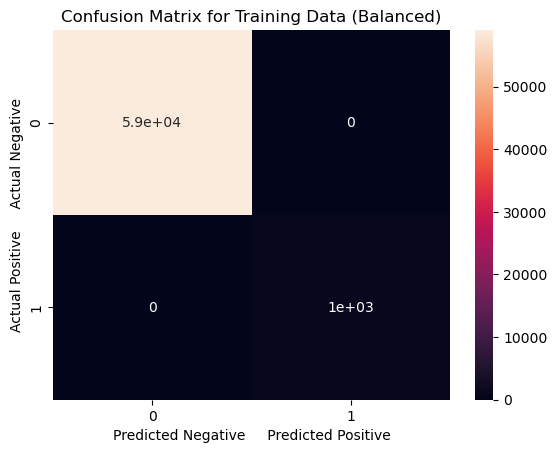

[[15614    11]
 [  166   209]]


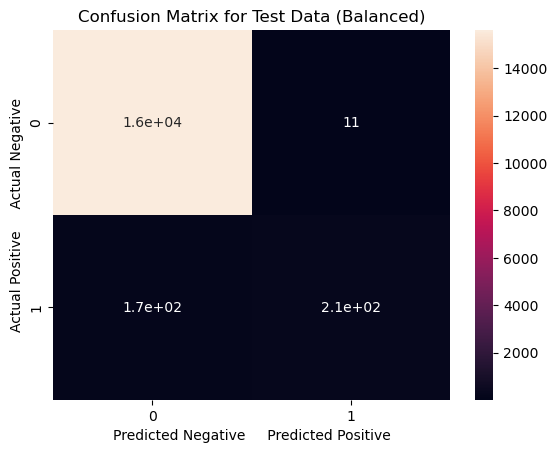

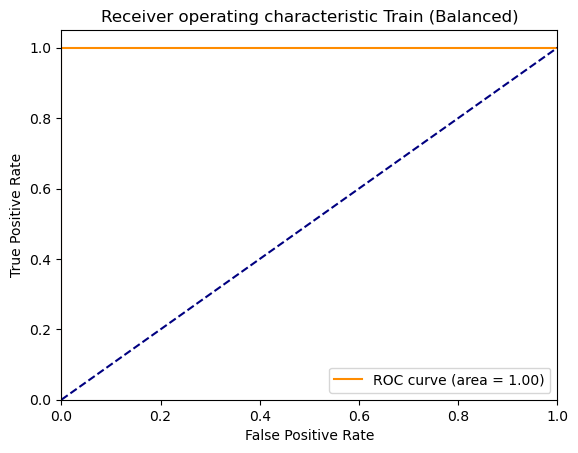

Training misclassification rate is:  0.0


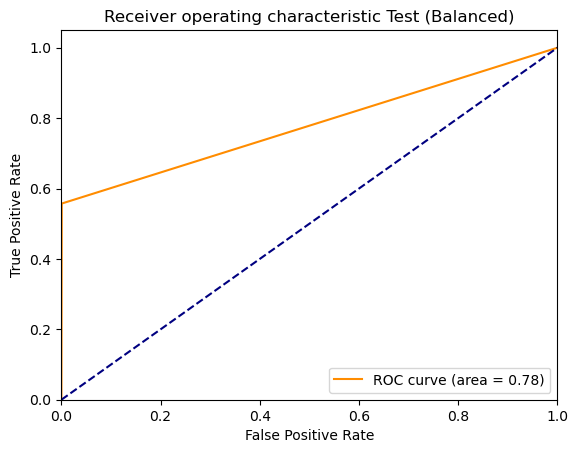

Test misclassification rate is:  0.011062499999999975
The Out of Bag error is:  0.007449999999999957  and the test error is  0.011062499999999975
The balanced set had a higher test misclassification rate of 0.011062499999999975 compared to 0.008000000000000007, and also a higher out of bag error of 0.007449999999999957 compared to 0.006216666666666648 


In [62]:
### BALANCED
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_train)
y_predict_test = clf.predict(X_test)


#confusion matrix
trainMatrix = confusion_matrix(y_train,y_predict)
print(trainMatrix)
sns.heatmap(trainMatrix,annot = True)
plt.title("Confusion Matrix for Training Data (Balanced)")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()

testMatrix = confusion_matrix(y_test,y_predict_test)
print(testMatrix)
sns.heatmap(testMatrix,annot = True)
plt.title("Confusion Matrix for Test Data (Balanced)")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()

# ROC, AUC, misclassification
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_predict)
roc_auc_train = auc(fpr_train,tpr_train)


plt.plot(fpr_train, tpr_train, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_train)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Train (Balanced)")
plt.legend(loc="lower right")
plt.show()
print("Training misclassification rate is: ", 1 - accuracy_score(y_train, y_predict))

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_predict_test)
roc_auc_test = auc(fpr_test,tpr_test)

plt.plot(fpr_test, tpr_test, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_test)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Test (Balanced)")
plt.legend(loc="lower right")
plt.show()
print("Test misclassification rate is: ", 1 - accuracy_score(y_test, y_predict_test))


#out of bag error
oob = 1 - clf.oob_score_
testErr = 1 - clf.score(X_test, y_test)
print("The Out of Bag error is: ", oob, " and the test error is ", testErr)
print("The balanced set had a higher test misclassification rate of 0.011062499999999975 compared to 0.008000000000000007, and also a higher out of bag error of 0.007449999999999957 compared to 0.006216666666666648 ")

## (e) XGBoost and Model Trees
### In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has PjβjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. 

### Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [40]:
alphas=[0, 0.001, 0.003, 0.005, 0.007, 0.01]

In [24]:
scores = []
#data_dmatrix = xgboost.DMatrix(data=X,label=y, enable_categorical=True)
for a in alphas:
    params = {"objective":"reg:logistic",'alpha': a}
    xgb_clf = XGBClassifier(**params)
    # fit the classifier to the training data
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    scores.append({"alpha":a, "mse":accuracy_score(y_test, y_pred)})

scores = pd.DataFrame(scores)


XGBoost model accuracy score: 0.9937
XGBoost model accuracy score: 0.9938
XGBoost model accuracy score: 0.9939
XGBoost model accuracy score: 0.9940
XGBoost model accuracy score: 0.9940
XGBoost model accuracy score: 0.9941


In [25]:
# option 2
scores_2 = []
allX = pd.concat([X_train, X_test])
allY = pd.concat([y_train, y_test])
data_dmatrix = xgb.DMatrix(data=allX,label=allY, enable_categorical=True)
for a in alphas:
    params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': a}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
    scores_2.append({"alpha":a, "mse":(cv_results["test-rmse-mean"]).iloc[-1]})

scores_2 = pd.DataFrame(scores_2)
minVal2 = scores_2.iloc[scores_2[['mse']].idxmin(),:]
print(minVal2)

   alpha       mse
1  0.001  0.072623


[[59000     0]
 [    1   999]]


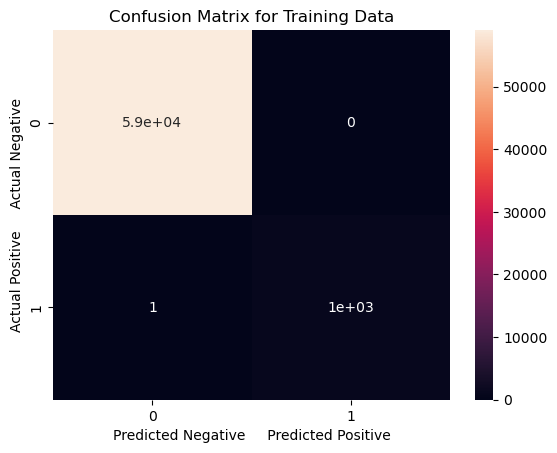

[[15607    18]
 [   81   294]]


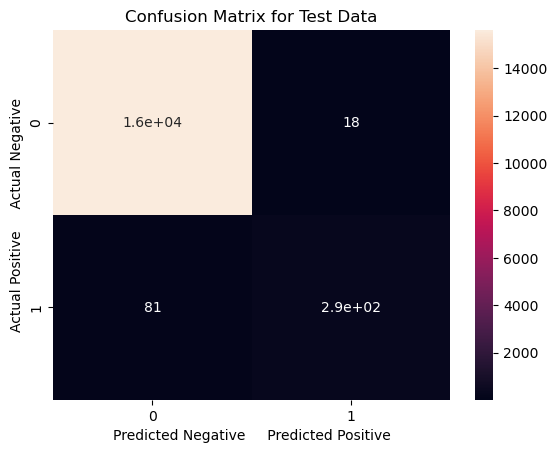

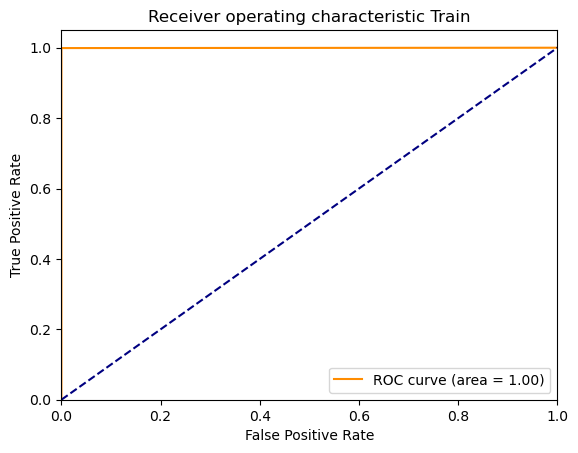

Training misclassification rate is:  1.666666666666483e-05


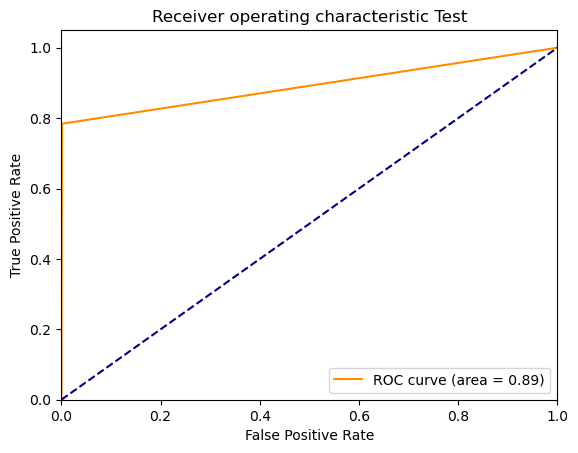

Test misclassification rate is:  0.0061875000000000124
The test error is  0.008000000000000007


In [28]:
minVal = scores.iloc[scores[['mse']].idxmax(),:]
a = minVal2["alpha"]
#once we have min alpha: re-train

params = {"objective":"reg:logistic",'alpha': 0.001}
xgb_clf = XGBClassifier(**params)
# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
y_predict = xgb_clf.predict(X_train)
y_predict_test = xgb_clf.predict(X_test)



#confusion matrix
trainMatrix = confusion_matrix(y_train,y_predict)
print(trainMatrix)
sns.heatmap(trainMatrix,annot = True)
plt.title("Confusion Matrix for Training Data")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()

testMatrix = confusion_matrix(y_test,y_predict_test)
print(testMatrix)
sns.heatmap(testMatrix,annot = True)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()


# ROC, AUC, misclassification
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_predict)
roc_auc_train = auc(fpr_train,tpr_train)


plt.plot(fpr_train, tpr_train, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_train)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Train")
plt.legend(loc="lower right")
plt.show()
print("Training misclassification rate is: ", 1 - accuracy_score(y_train, y_predict))

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_predict_test)
roc_auc_test = auc(fpr_test,tpr_test)

plt.plot(fpr_test, tpr_test, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_test)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Test")
plt.legend(loc="lower right")
plt.show()
print("Test misclassification rate is: ", 1 - accuracy_score(y_test, y_predict_test))


#error
testErr = 1 - clf.score(X_test, y_test)
print("The test error is ", testErr)

### f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.


In [47]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)

# option 2
scores_sm = []
data_dmatrix = xgb.DMatrix(data=allX,label=allY, enable_categorical=True)
for a in alphas:
    X_res, y_res = sm.fit_resample(allX, allY)
    data_dmatrix = xgb.DMatrix(data=X_res,label=y_res, enable_categorical=True)
    params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': a}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
    scores_sm.append({"alpha":a, "mse":(cv_results["test-rmse-mean"]).iloc[-1]})

scores_sm = pd.DataFrame(scores_sm)
minValSM = scores_sm.iloc[scores_sm[['mse']].idxmin(),:]
print(minValSM)


   alpha       mse
5   0.01  0.098945


[[59000     0]
 [    1 58999]]


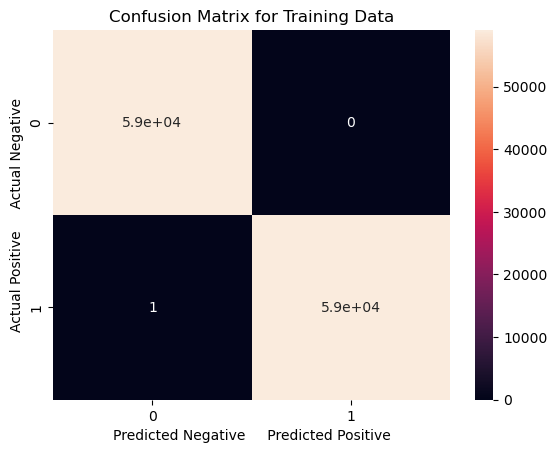

[[15576    49]
 [   62   313]]


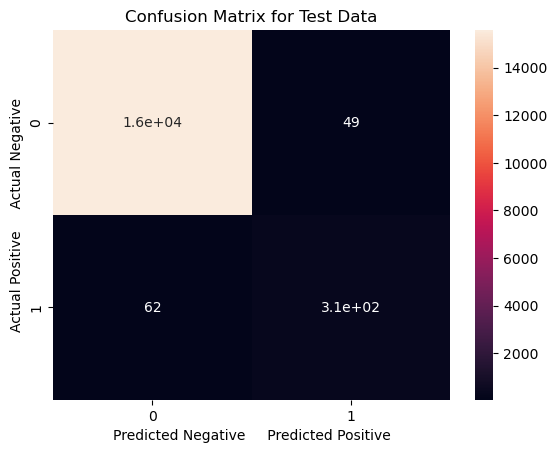

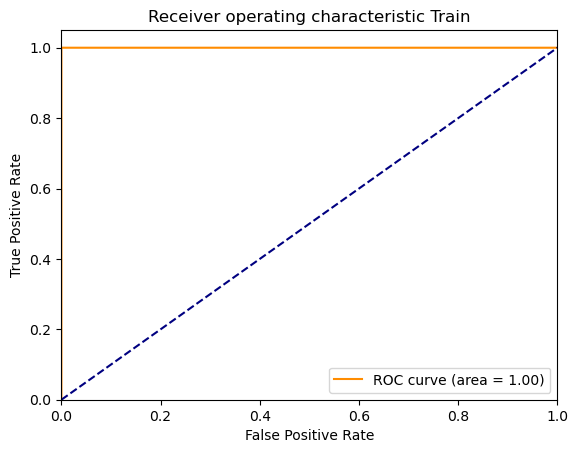

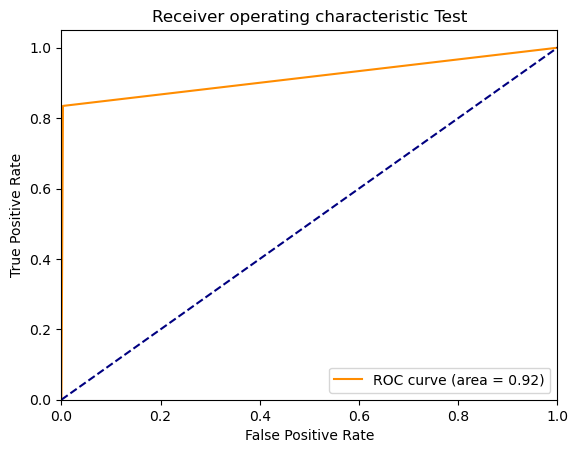

Test misclassification rate is:  0.006937500000000041
The test error is  0.008000000000000007


In [49]:
a = minValSM["alpha"]
#once we have min alpha: re-train

params = {"objective":"reg:logistic",'alpha': 0.01}
xgb_clf = XGBClassifier(**params)
# fit the classifier to the training data
X_res, y_res = sm.fit_resample(X_train, y_train)
xgb_clf.fit(X_res, y_res)
y_predict = xgb_clf.predict(X_res)
y_predict_test = xgb_clf.predict(X_test)



#confusion matrix
trainMatrix = confusion_matrix(y_res,y_predict)
print(trainMatrix)
sns.heatmap(trainMatrix,annot = True)
plt.title("Confusion Matrix for Training Data")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()

testMatrix = confusion_matrix(y_test,y_predict_test)
print(testMatrix)
sns.heatmap(testMatrix,annot = True)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Negative     Predicted Positive")
plt.ylabel("Actual Positive     Actual Negative")
plt.show()


# ROC, AUC, misclassification
fpr_train, tpr_train, thresholds_train = roc_curve(y_res, y_predict)
roc_auc_train = auc(fpr_train,tpr_train)


plt.plot(fpr_train, tpr_train, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_train)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Train")
plt.legend(loc="lower right")
plt.show()

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_predict_test)
roc_auc_test = auc(fpr_test,tpr_test)

plt.plot(fpr_test, tpr_test, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc_test)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Test")
plt.legend(loc="lower right")
plt.show()
print("Test misclassification rate is: ", 1 - accuracy_score(y_test, y_predict_test))


#error
testErr = 1 - clf.score(X_test, y_test)
print("The test error is ", testErr)

### 2. ISLR 6.6.3

(a) iv. <br>
As we increase s from 0, the the value of Bj will be less constrained until we eventually get to the same value of least squares error.<br>
(b) ii.<br>
For the test RSS, we will initially decrease when J = 0, but it will increase once the values begin to fit the training set.<br>
(c) iii.<br>
The variance will steadily increase as the model overfits.<br>
(d) iv. <br>
The squared bias will decrease as the model fits the set better and better, so bias will decrease.<br>
(e) v.<br>
The irreducible error can never be modified, as it is the amount of error that can never be decreased regardless of the model

### 3. ISLR 6.6.5

(a) Since x11 = x12 and x21 = x22, these can be rewritten as x1 and x2. And so, the ridge regression problem can be written as (y1 -B1x1 - B2x1)^2 + (y2 -B1x2 - B2x2)^2 + $\lambda$ (B1^2 + B2^2)

(b) Expanding the squares of the above equation gives:

y1^2 - 2y1b1x1 - 2y1b2x1  + b1^2x1^2 + 2b1b2x1^2+ b2^2x1^2 + 
y2^2 - 2y1b1x2 - 2y1b2x2  + b1^2x2^2 + 2b1b2x2^2+ b2^2x2^2 + lambdab1^2 + lambdab2^2

Then taking the derivative wrt B1:

0 - 2y1x1 + 2b1x1^2 + 2b2x1^2 -2y1x2 + 2b1x2^2 + 2b2x2^2 + 2lambdab1

Then taking the derivative wrt B2:

0 - 2y1x1 + 2b2x1^2 + 2b1x1^2 -2y1x2 + 2b2x2^2 + 2b1x2^2 + 2lambdab2

and we see that B1 = B2.

(c) If βˆ1 = β2, the problem becomes: (y1 -B1x1 - B2x1)^2 + (y2 -B1x2 - B2x2)^2 + $\lambda$ (|B1| + |B2|)

(d) 

### 4. ISLR 8.4.5

Under majority voting: <br>
the count of P(class=red | X) < 0.5 = 4 (0.1, 0.15, 0.2, 0.2) <br>
the count of P(class=red | X) >= 0.5 = 6 (0.55, 0.6, 0.6, 0.65, 0.7, and 0.75) <br>
Since the count of >=0.5 is greater (6 vs 4), the classification will be red.
<br>
Under average probability: <br>
the average of P(class=red | X) = sum(0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75)/10 = 4.5/10 = 0.45, which is less than 0.5 so the classification will be green. <br>

### 5. ISLR 9.7.3

### (a)

Text(0.5, 1.0, '5.a')

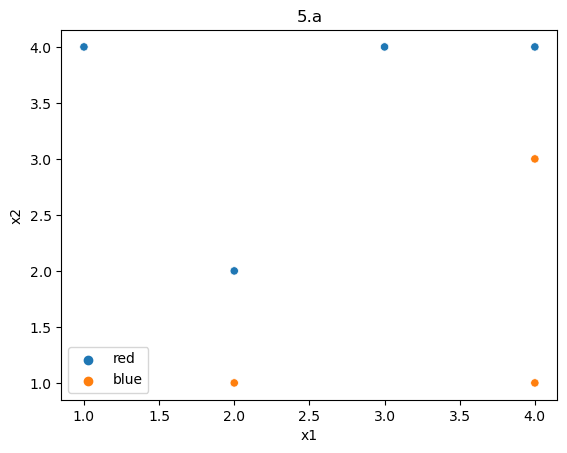

In [92]:
n = 7
p = 2
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']
yc = [1,1,1,1,0,0,0]

sns.scatterplot(x1, x2, hue = y)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("5.a")

### (b)
The equation of the line given m = 1 and c=-0.5 is:  -(0.5) + x1 - x2 = 0

Text(0.5, 1.0, '5.b')

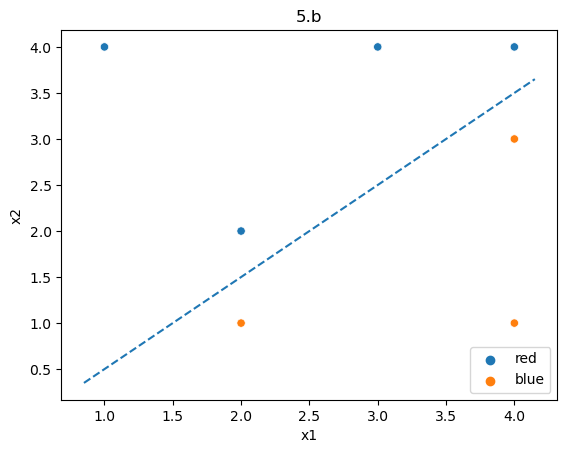

In [98]:
## PART B

sns.scatterplot(x1, x2, hue = y)
pltgca=plt.gca()
x_l = np.array(pltgca.get_xlim())
y_l = -(0.5) +1*x_l
plt.plot(x_l,y_l,'--')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("5.b")

### (c) “Classify to Red if X2 - X1 + 0.5 > 0, and classify to Blue otherwise.” β0 = 0.5, β1 = -1, and β2 = 1.

### (d)

Text(0.5, 1.0, '5.b')

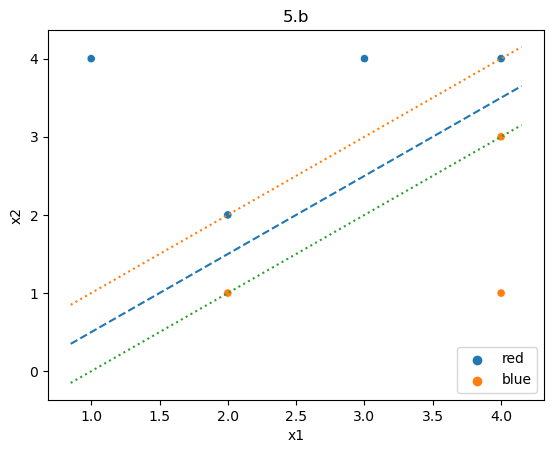

In [100]:
## PART D

sns.scatterplot(x1, x2, hue = y)
pltgca=plt.gca()
x_l = np.array(pltgca.get_xlim())
y_l = -(0.5) +1*x_l
plt.plot(x_l,y_l,'--')
plt.plot(x_l,x_l, ':')
plt.plot(x_l,x_l - 1, ':')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("5.d")

### (e). The support vectors are the observations which lie on the dotted lines in the figure of part d. 
### (f) Since the seventh observation is not near or on any of the lines, it is not a support vector, so moving it in any direction would not alter the hyperplane.
### (g) x1 - 0.2 - x2 = 0

Text(0.5, 1.0, '5.g')

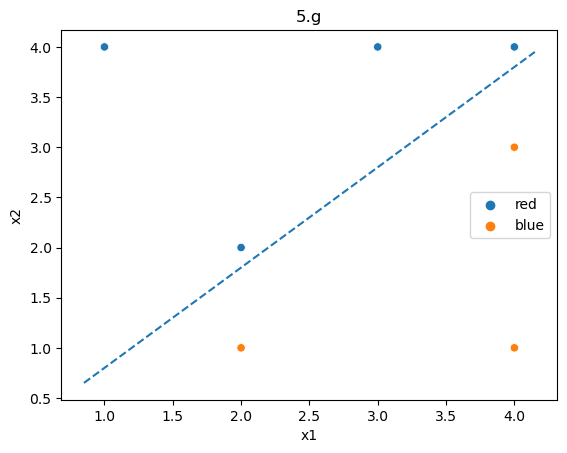

In [111]:
## PART G

sns.scatterplot(x1, x2, hue = y)
pltgca=plt.gca()
x_l = np.array(pltgca.get_xlim())
y_l = -(0.2) +1*x_l
plt.plot(x_l,y_l,'--')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("5.g")

### (h)

Text(0.5, 1.0, '5.h')

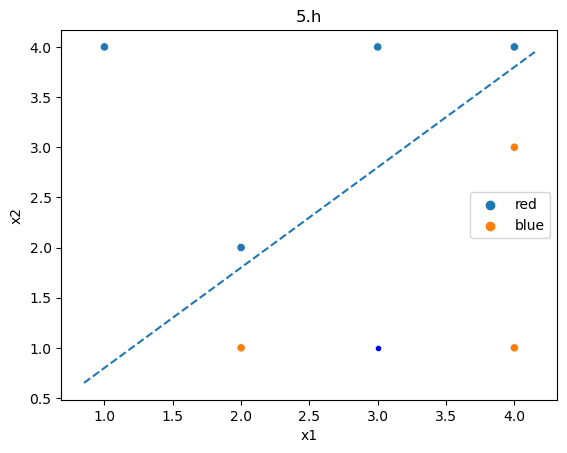

In [110]:
## PART H

sns.scatterplot(x1, x2, hue = y)
pltgca=plt.gca()
x_l = np.array(pltgca.get_xlim())
y_l = -(0.2) +1*x_l
plt.plot(x_l,y_l,'--')
plt.plot(3,1, '.',color = 'blue')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("5.h")

# References
https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779 <br>
https://datatofish.com/correlation-matrix-pandas/ <br>
https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/ <br>
